Model Directory: m2_00_global_2000_2018_band31

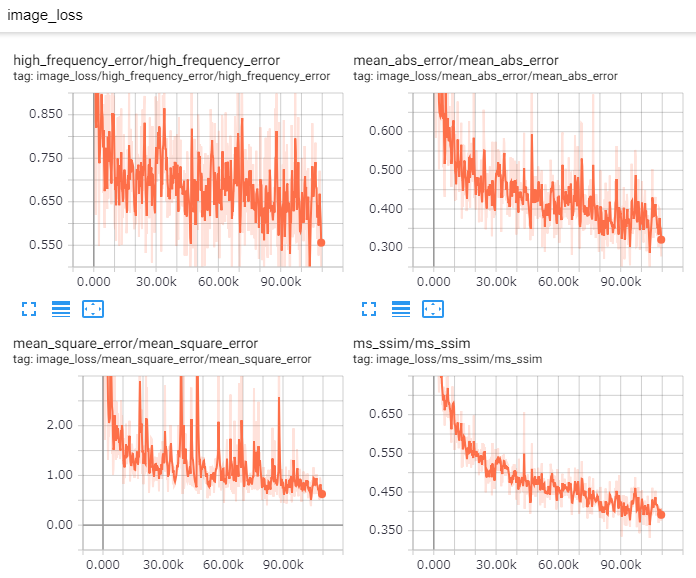

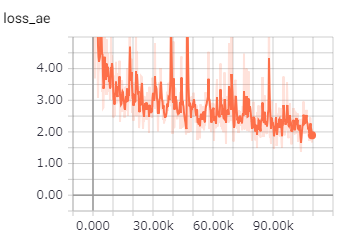

In [1]:
import os
import glob
import sys
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from pyhdf.SD import SD, SDC
from sklearn.cluster import AgglomerativeClustering
from matplotlib import patches as mpl_patches

In [2]:
sys.path.insert(1,os.path.join(sys.path[0],"/home/tkurihana/scratch-midway2/data/MOD02"))
from lib_modis02 import load_tfrecord, _get_imgs,  _get_num_imgs

In [3]:
sys.path.insert(1, os.path.join(sys.path[0],"/home/tkurihana/scratch-midway2/data/MOD06/" ) )
from analysis_lib import _get_colors, _gen_patches, _anl_agl
from analysis_lib import cluster_plotting2, cluster_plotting

In [4]:
datadir = "/project2/foster/clouds/output/mod02/m2_00_global_2000_2018_band31"

In [5]:
step = 100000

### Load Model

In [6]:
encoder_def = datadir+'/encoder.json'
encoder_weight = datadir+'/encoder-'+str(step)+'.h5'
with open(encoder_def, "r") as f:
    encoder = tf.keras.models.model_from_json(f.read())
encoder.load_weights(encoder_weight)

/home/tkurihana/.conda/envs/tf-cpu/lib/python3.6/site-packages/tensorflow/python/keras/layers/core.py:791: UserWarning: models is not loaded, but a Lambda layer uses it. It may cause errors.
  , UserWarning)


In [7]:
decoder_def = datadir+'/decoder.json'
decoder_weight = datadir+'/decoder-'+str(step)+'.h5'
with open(decoder_def, "r") as f:
    decoder = tf.keras.models.model_from_json(f.read())
decoder.load_weights(decoder_weight)

In [15]:
mod_datadir = "/home/tkurihana/scratch-midway2/data/MOD02/clouds_laads_preprocessed_2000_2018_band31_test"
filelist = glob.glob(mod_datadir+'/*')

In [16]:
nfiles = []
for ifile in filelist:
    nfiles += [_get_num_imgs(ifile)]
nfiles

[90, 100]

In [17]:
load_data = (load_tfrecord(filelist[0], (128,128,4)))
imgs, coords, names = _get_imgs(load_data, n=nfiles[0])

Instructions for updating:
Use `tf.data.experimental.parallel_interleave(...)`.
Tensor("ParseSingleExample/ParseSingleExample:1", shape=(), dtype=string) Tensor("ParseSingleExample/ParseSingleExample:0", shape=(2,), dtype=int64) Tensor("random_crop:0", shape=(128, 128, 4), dtype=float64)
<ParallelInterleaveDataset shapes: ((), (2,), (128, 128, 4)), types: (tf.string, tf.int64, tf.float64)>
Instructions for updating:
Use `tf.data.Dataset.batch(..., drop_remainder=True)`.


#### Check test image

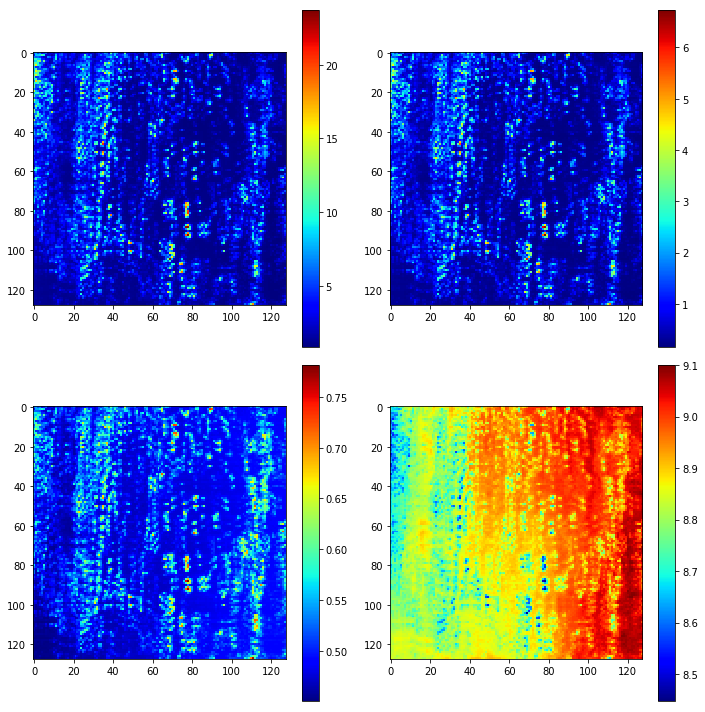

In [18]:
tmp_img = imgs[30]
fig = plt.figure(figsize=(10,10))
for idx, i in enumerate(range(4)):
    ax = plt.subplot(2,2,idx+1)
    plt.imshow(tmp_img[:,:,i], cmap='jet')
    plt.colorbar()
fig.tight_layout()
plt.show()

#### Construction

In [19]:
encoded_img = encoder.predict(imgs)

In [20]:
decoded_img = decoder.predict(encoded_img)

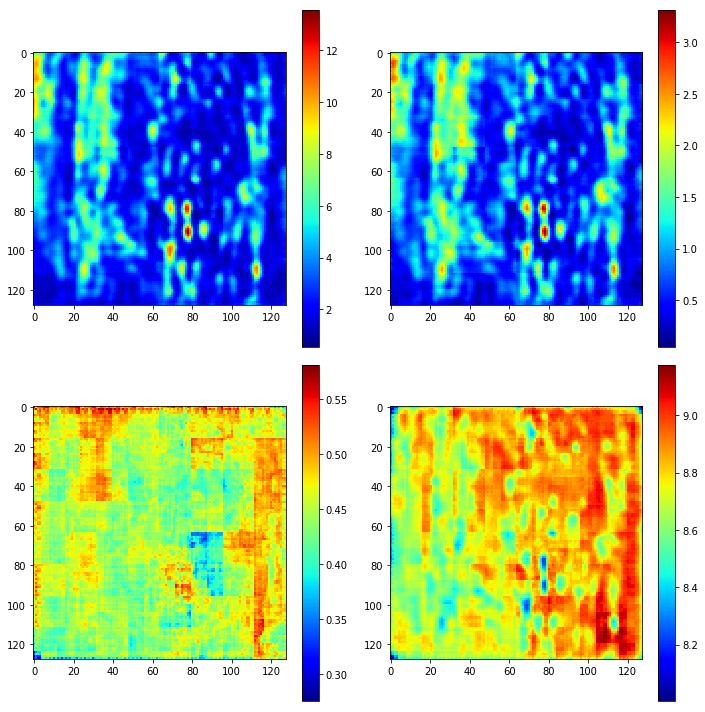

In [21]:
tmp_decod = decoded_img[30]
fig = plt.figure(figsize=(10,10))
for idx, i in enumerate(range(4)):
    ax = plt.subplot(2,2,idx+1)
    plt.imshow(tmp_decod[:,:,i], cmap='jet')
    plt.colorbar()
fig.tight_layout()
plt.show()

In [22]:
res = imgs - decoded_img

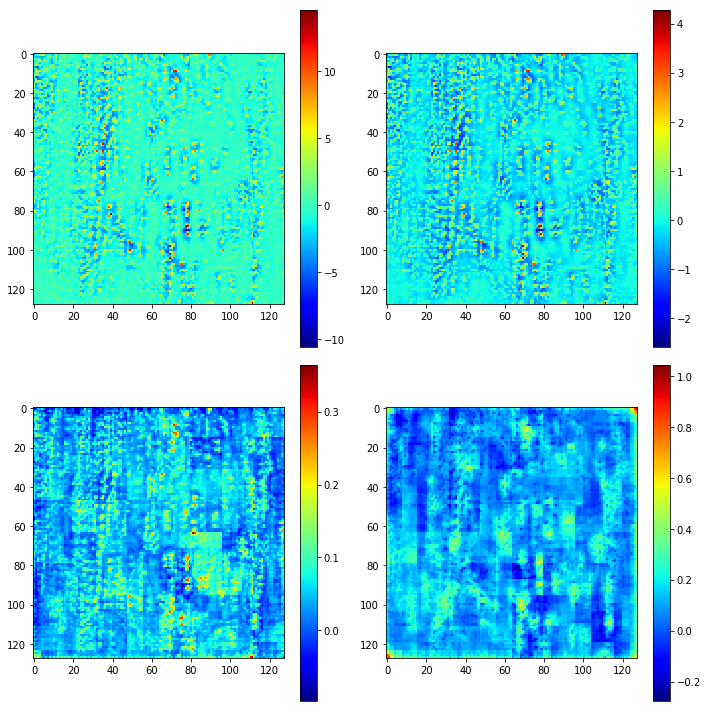

In [23]:
tmp_res = res[30]
fig = plt.figure(figsize=(10,10))
for idx, i in enumerate(range(4)):
    ax = plt.subplot(2,2,idx+1)
    plt.imshow(tmp_res[:,:,i], cmap='jet')
    plt.colorbar()
fig.tight_layout()
plt.show()

### Clustering example on a coast of new-zealand

In [8]:
hdf_datadir = "/project2/chard/clouds/data/MOD02/04"

In [9]:
hdf_filelist=[
    hdf_datadir+'/MOD021KM.A2015179.mosaic.061.2019112165625.mcgscs_000501328368.EV_500_Aggr1km_RefSB_4.hdf',
    hdf_datadir+'/MOD021KM.A2015179.mosaic.061.2019112165625.mcgscs_000501328368.EV_500_Aggr1km_RefSB_5.hdf',
    hdf_datadir+'/MOD021KM.A2015179.mosaic.061.2019112165625.mcgscs_000501328368.EV_1KM_Emissive_1.hdf',
    hdf_datadir+'/MOD021KM.A2015179.mosaic.061.2019112165625.mcgscs_000501328368.EV_1KM_Emissive_11.hdf'
]

band 6,7,20,31

#### decode hdf

In [11]:
def proc_sds(sds_array):
    """
    IN: array = hdf_data.select(variable_name)
    """
    array = sds_array.get()
    array = array.astype(np.float64)
    
    # check bandinfo
    _bands = sds_array.attributes()['band_names']
    print("Process bands", _bands)
    bands = _bands.split(",")
    
    # nan process
    nan_idx = np.where( array == sds_array.attributes()['_FillValue'])
    if len(nan_idx) > 0:
        array[nan_idx] = np.nan
    else:
        pass
    
    # radiacne offset
    offset = sds_array.attributes()['radiance_offsets']
    offset_array = np.zeros(array.shape) # new matrix
    offset_ones  = np.ones(array.shape)  # 1 Matrix 
    offset_array[:,:] = array[:,:] - offset*offset_ones[:,:]
    
    # radiance scale
    scales = sds_array.attributes()['radiance_scales']
    scales_array = np.zeros(array.shape) # new matrix
    scales_array[:,:] = scales*offset_array[:,:]
    return scales_array, bands

In [12]:
b6_hdf = SD(hdf_filelist[0], SDC.READ)
b7_hdf = SD(hdf_filelist[1], SDC.READ)
b20_hdf = SD(hdf_filelist[2], SDC.READ)
b31_hdf = SD(hdf_filelist[3], SDC.READ)

In [13]:
b6_sds = b6_hdf.select("EV_500_Aggr1km_RefSB")
b7_sds = b7_hdf.select("EV_500_Aggr1km_RefSB")
b20_sds = b20_hdf.select("EV_1KM_Emissive")
b31_sds = b31_hdf.select("EV_1KM_Emissive")

In [14]:
b6_array, b6 = proc_sds(b6_sds)
b7_array, b7 = proc_sds(b7_sds)
b20_array, b20 = proc_sds(b20_sds)
b31_array, b31 = proc_sds(b31_sds)

Process bands 6
Process bands 7
Process bands 20
Process bands 31


In [24]:
nx, ny = b6_array.shape

In [25]:
d_list = [
    b6_array.reshape(nx,ny,1),
    b7_array.reshape(nx,ny,1),
    b20_array.reshape(nx,ny,1),
    b31_array.reshape(nx,ny,1),
]

In [26]:
mod02_img = np.concatenate(d_list, axis=2)

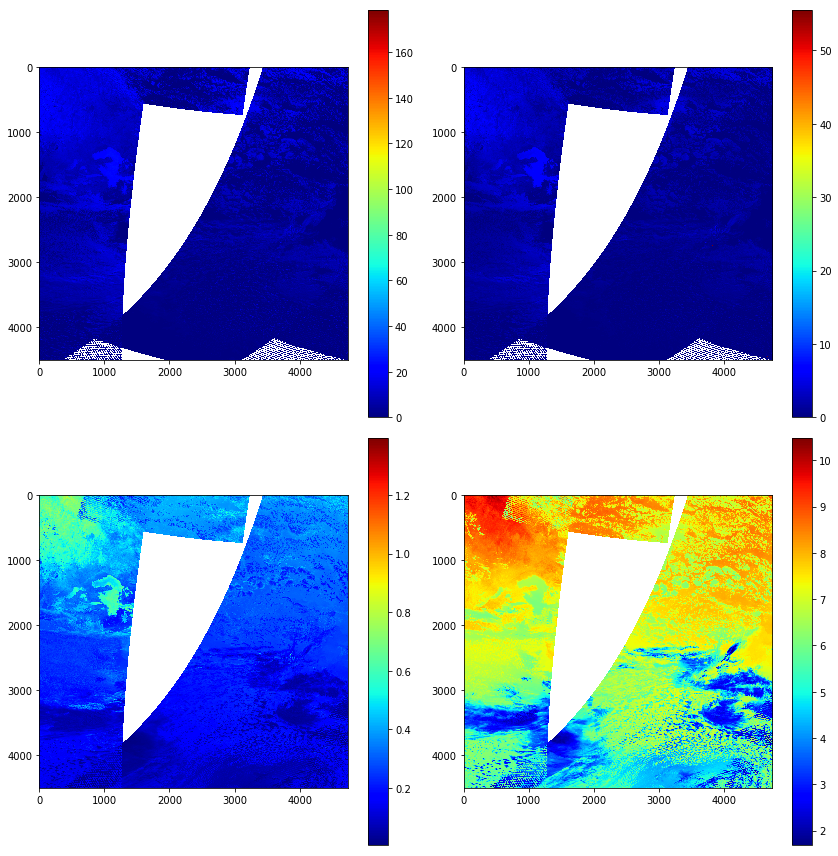

In [27]:
fig = plt.figure(figsize=(12,12))
for idx, i in enumerate(range(4)):
    ax = plt.subplot(2,2,idx+1)
    plt.imshow(mod02_img[:,:,i], cmap='jet')
    plt.colorbar()
fig.tight_layout()
plt.show()

### Clustering bottleneck layer

In [28]:
def const_array(patches):
    nx, ny = patches.shape[:2]
    patches_list = []
    xy_list = []
    for i in range(nx):
        for j in range(ny):
            if not np.isnan(patches[i,j]).any():
                patches_list += [patches[i,j]]
                xy_list += [(i,j)]
    return patches_list, xy_list

In [29]:
patches = _gen_patches(mod02_img, normalization=False)
patches.shape

(35, 37, 128, 128, 4)

In [30]:
patches_list, xy_list = const_array(patches)

In [31]:
encs_list = []
for i in patches_list:
    encs = encoder.predict(i.reshape(1,128,128,4))
    encs_list += [encs.mean(axis=(1,2))]

In [32]:
features = np.concatenate(encs_list, axis=0)

In [33]:
features.shape

(1009, 128)

In [34]:
n_cluster = 10

In [35]:
method = AgglomerativeClustering(n_clusters=n_cluster)
_patches_labels = method.fit_predict(features)

In [36]:
ix, iy = patches.shape[:2]
img_array = np.zeros((ix,iy)).astype(np.float64)
img_array[:,:] = np.nan
for idx, (x,y) in enumerate(xy_list):
    img_array[x,y] = _patches_labels[idx]

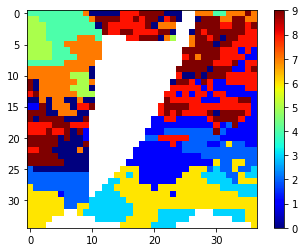

In [37]:
plt.imshow(img_array, cmap='jet')
plt.colorbar()

### Align to each image

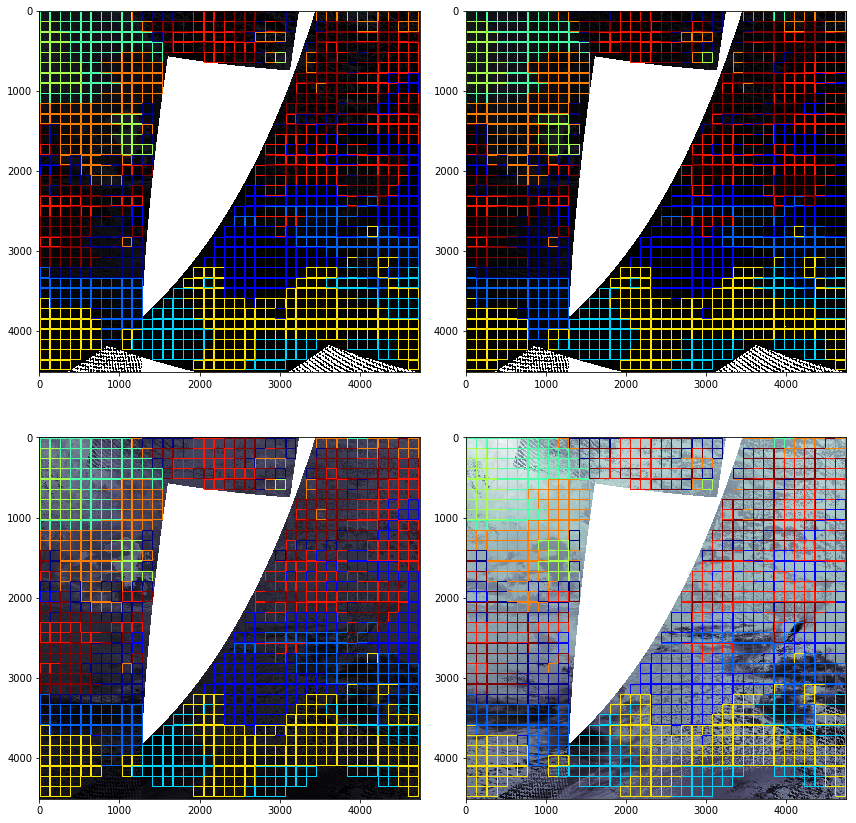

In [38]:
fig = plt.figure(figsize=(12,12))

line_width = 2
SHAPE = 128,128
colors = _get_colors(n=n_cluster)
for idx, i in enumerate(range(4)):
    ax = plt.subplot(2,2,idx+1)
    plt.imshow(mod02_img[:,:,i], cmap='bone')
    for i in range(patches.shape[0]):
        for j in range(patches.shape[1]):
            if not np.isnan(img_array[i,j]):
                ax.add_patch(mpl_patches.Rectangle(
                      (j * SHAPE[0] + line_width , i * SHAPE[1] + line_width ),
                      width=SHAPE[0] - line_width * 2,
                      height=SHAPE[1] - line_width * 2,
                      linewidth=1,
                      edgecolor=colors[int(img_array[i,j])],
                      facecolor="none"                 
                      ))
fig.tight_layout()
plt.show()

### Align to visible image

In [39]:
vis_file = hdf_datadir+'/MOD021KM.A2015179.mosaic.061.2019112165625.mcgscs_000501328368.EV_250_Aggr1km_RefSB_1.hdf'

In [40]:
vhdf = SD(vis_file, SDC.READ)

In [41]:
vhdf_sds = vhdf.select("EV_250_Aggr1km_RefSB")

In [42]:
vhdf_array, vis_band = proc_sds(vhdf_sds)

Process bands 1


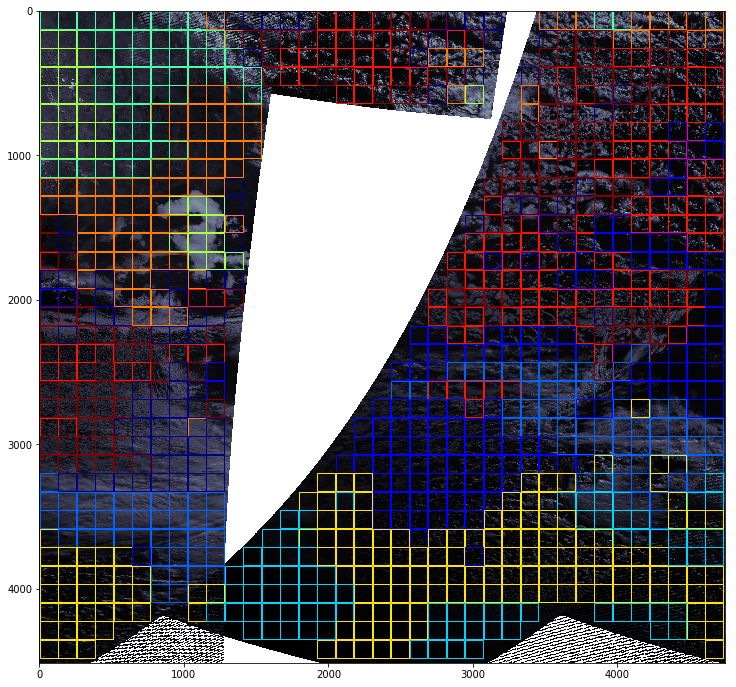

In [43]:
fig = plt.figure(figsize=(20,20))

line_width = 2
SHAPE = 128,128
colors = _get_colors(n=n_cluster)
for idx, i in enumerate(range(1)):
    ax = plt.subplot(2,2,idx+1)
    plt.imshow(vhdf_array, cmap='bone')
    for i in range(patches.shape[0]):
        for j in range(patches.shape[1]):
            if not np.isnan(img_array[i,j]):
                ax.add_patch(mpl_patches.Rectangle(
                      (j * SHAPE[0] + line_width , i * SHAPE[1] + line_width ),
                      width=SHAPE[0] - line_width * 2,
                      height=SHAPE[1] - line_width * 2,
                      linewidth=1,
                      edgecolor=colors[int(img_array[i,j])],
                      facecolor="none"                 
                      ))
fig.tight_layout()
plt.show()

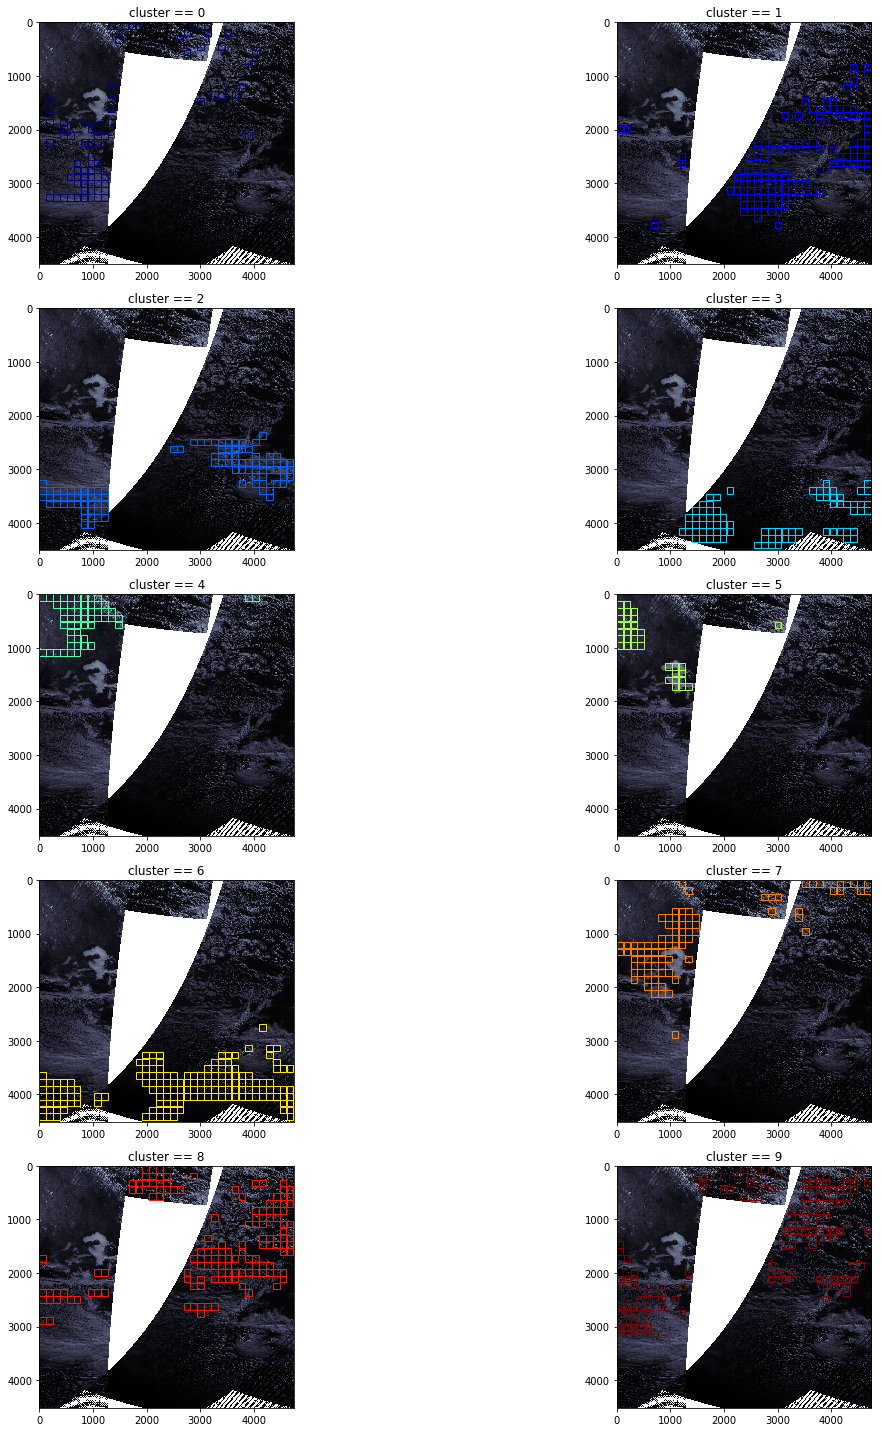

In [44]:
fig = plt.figure(figsize=(20,20))

line_width = 2
SHAPE = 128,128
colors = _get_colors(n=n_cluster)
for idx, icluster in enumerate(range(10)):
    ax = plt.subplot(5,2,idx+1)
    plt.imshow(vhdf_array, cmap='bone')
    ax.set_title("cluster == %d" % idx)
    for i in range(patches.shape[0]):
        for j in range(patches.shape[1]):
            if not np.isnan(img_array[i,j]):
                if img_array[i,j] == icluster:
                    ax.add_patch(mpl_patches.Rectangle(
                      (j * SHAPE[0] + line_width , i * SHAPE[1] + line_width ),
                      width=SHAPE[0] - line_width * 2,
                      height=SHAPE[1] - line_width * 2,
                      linewidth=1,
                      edgecolor=colors[int(img_array[i,j])],
                      facecolor="none"                 
                      ))
fig.tight_layout()
plt.show()